# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [17]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

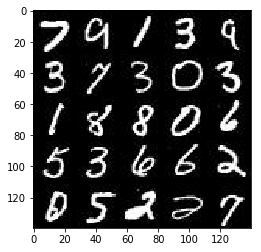

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

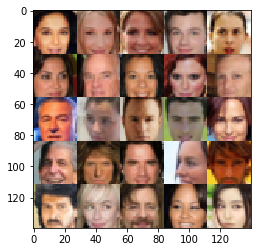

In [19]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [21]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [35]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    keep_prob = 0.8
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.nn.dropout(x3, keep_prob)
       
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    keep_prob = 0.5
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 2, strides=1, padding='same')
        x2 = tf.nn.dropout(x2, keep_prob)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x256 now
        
        x4 = tf.layers.conv2d_transpose(x3, 256, 2, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 14x14x256 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.nn.dropout(x4, keep_prob)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [38]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    import numpy as np
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real) * (np.random.uniform(0.7, 1.0))))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [44]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
 
    steps = 0
    
    samples, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
        
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0 #render dtype=float32
                
                # Run optimizers
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                # Run g-opt twice
                #sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                
                if steps % 20 == 0:
                    #print stepwise D/G losses
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

               
                if steps % 100 == 0:
                    #print generator ouput every 100 steps
                     show_generator_output(sess, 16, input_z, image_channels, data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.8792... Generator Loss: 0.0958
Epoch 1/2... Discriminator Loss: 2.4377... Generator Loss: 0.2302
Epoch 1/2... Discriminator Loss: 2.6300... Generator Loss: 0.0935
Epoch 1/2... Discriminator Loss: 1.7334... Generator Loss: 0.1757
Epoch 1/2... Discriminator Loss: 1.5861... Generator Loss: 0.4000


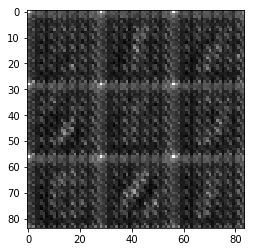

Epoch 1/2... Discriminator Loss: 1.8846... Generator Loss: 0.3054
Epoch 1/2... Discriminator Loss: 2.2737... Generator Loss: 0.1999
Epoch 1/2... Discriminator Loss: 1.7118... Generator Loss: 0.2940
Epoch 1/2... Discriminator Loss: 1.9248... Generator Loss: 0.2486
Epoch 1/2... Discriminator Loss: 1.6121... Generator Loss: 0.3203


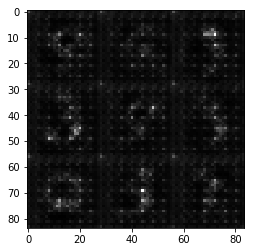

Epoch 1/2... Discriminator Loss: 1.7736... Generator Loss: 0.3534
Epoch 1/2... Discriminator Loss: 1.7277... Generator Loss: 0.4980
Epoch 1/2... Discriminator Loss: 1.6643... Generator Loss: 0.4128
Epoch 1/2... Discriminator Loss: 1.4722... Generator Loss: 0.3956
Epoch 1/2... Discriminator Loss: 1.3857... Generator Loss: 0.3631


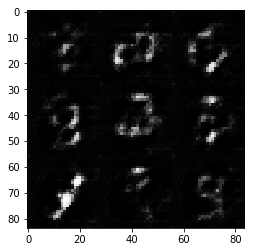

Epoch 1/2... Discriminator Loss: 1.5233... Generator Loss: 0.2981
Epoch 1/2... Discriminator Loss: 1.5353... Generator Loss: 0.2386
Epoch 1/2... Discriminator Loss: 1.3935... Generator Loss: 0.5661
Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 0.6377
Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 0.2856


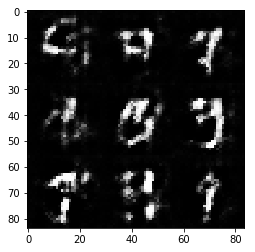

Epoch 1/2... Discriminator Loss: 1.6323... Generator Loss: 0.1882
Epoch 1/2... Discriminator Loss: 1.1683... Generator Loss: 0.3786
Epoch 1/2... Discriminator Loss: 1.2380... Generator Loss: 0.3948
Epoch 1/2... Discriminator Loss: 1.3301... Generator Loss: 0.5075
Epoch 1/2... Discriminator Loss: 1.2814... Generator Loss: 0.3128


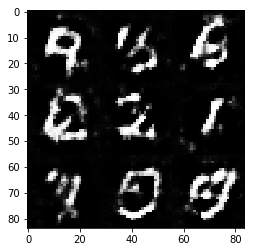

Epoch 1/2... Discriminator Loss: 1.4811... Generator Loss: 0.1880
Epoch 1/2... Discriminator Loss: 1.2596... Generator Loss: 0.4659
Epoch 1/2... Discriminator Loss: 1.4855... Generator Loss: 0.5693
Epoch 1/2... Discriminator Loss: 1.3779... Generator Loss: 0.3944
Epoch 1/2... Discriminator Loss: 1.3992... Generator Loss: 0.7787


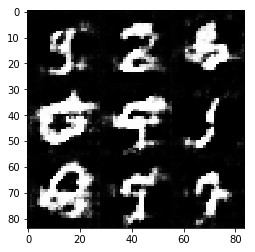

Epoch 1/2... Discriminator Loss: 1.6841... Generator Loss: 0.7356
Epoch 1/2... Discriminator Loss: 1.0493... Generator Loss: 0.5289
Epoch 1/2... Discriminator Loss: 1.3818... Generator Loss: 0.2118
Epoch 1/2... Discriminator Loss: 1.3688... Generator Loss: 0.3384
Epoch 1/2... Discriminator Loss: 1.3501... Generator Loss: 0.2996


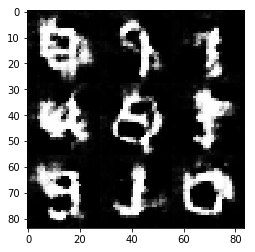

Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 0.4337
Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 0.4643
Epoch 1/2... Discriminator Loss: 1.4776... Generator Loss: 0.2104
Epoch 1/2... Discriminator Loss: 1.7423... Generator Loss: 0.3868
Epoch 1/2... Discriminator Loss: 1.4831... Generator Loss: 0.5350


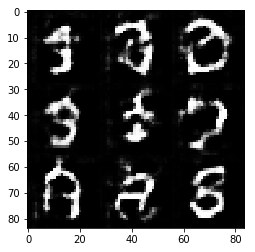

Epoch 1/2... Discriminator Loss: 1.2004... Generator Loss: 0.4244
Epoch 1/2... Discriminator Loss: 1.1597... Generator Loss: 0.5164
Epoch 1/2... Discriminator Loss: 1.2469... Generator Loss: 0.3745
Epoch 1/2... Discriminator Loss: 1.5076... Generator Loss: 0.2649
Epoch 1/2... Discriminator Loss: 1.4943... Generator Loss: 0.3828


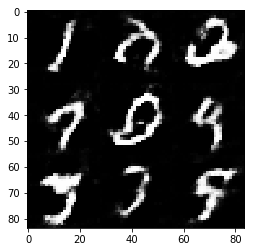

Epoch 1/2... Discriminator Loss: 1.3010... Generator Loss: 0.6928
Epoch 1/2... Discriminator Loss: 1.2163... Generator Loss: 0.7095
Epoch 1/2... Discriminator Loss: 0.9959... Generator Loss: 0.5329
Epoch 1/2... Discriminator Loss: 1.5533... Generator Loss: 0.2365
Epoch 1/2... Discriminator Loss: 1.2207... Generator Loss: 0.5660


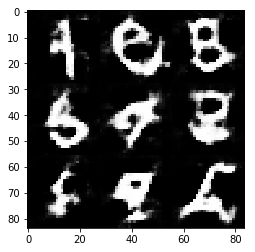

Epoch 1/2... Discriminator Loss: 1.3023... Generator Loss: 0.4612
Epoch 1/2... Discriminator Loss: 1.1559... Generator Loss: 0.5574
Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 0.4614
Epoch 1/2... Discriminator Loss: 1.2187... Generator Loss: 0.4314
Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 0.3096


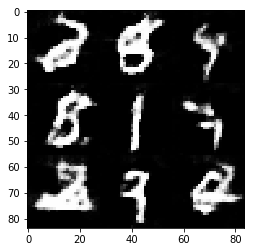

Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 0.2733
Epoch 1/2... Discriminator Loss: 1.3157... Generator Loss: 0.2406
Epoch 1/2... Discriminator Loss: 1.2742... Generator Loss: 0.3825
Epoch 1/2... Discriminator Loss: 1.2388... Generator Loss: 0.3853
Epoch 1/2... Discriminator Loss: 1.0864... Generator Loss: 0.5894


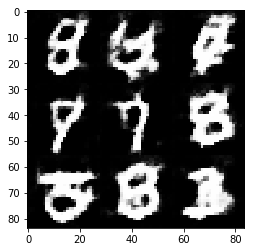

Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 0.6442
Epoch 1/2... Discriminator Loss: 1.1560... Generator Loss: 0.3895
Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 0.4853
Epoch 1/2... Discriminator Loss: 0.9847... Generator Loss: 0.6308
Epoch 1/2... Discriminator Loss: 1.2723... Generator Loss: 0.7568


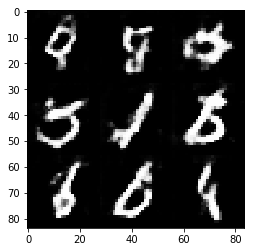

Epoch 1/2... Discriminator Loss: 0.9532... Generator Loss: 0.6220
Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 0.4064
Epoch 1/2... Discriminator Loss: 1.0599... Generator Loss: 0.5734
Epoch 1/2... Discriminator Loss: 0.9928... Generator Loss: 0.5395
Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 0.3011


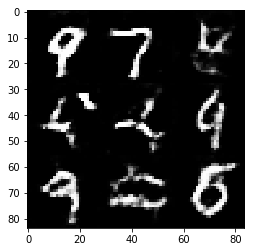

Epoch 1/2... Discriminator Loss: 1.5619... Generator Loss: 0.1734
Epoch 1/2... Discriminator Loss: 0.8310... Generator Loss: 1.1072
Epoch 1/2... Discriminator Loss: 1.0958... Generator Loss: 0.3889
Epoch 1/2... Discriminator Loss: 1.0641... Generator Loss: 0.3217
Epoch 1/2... Discriminator Loss: 1.1374... Generator Loss: 1.0431


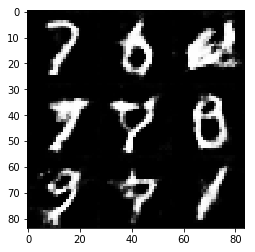

Epoch 1/2... Discriminator Loss: 1.0062... Generator Loss: 0.3478
Epoch 1/2... Discriminator Loss: 1.0924... Generator Loss: 0.2726
Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 0.3259
Epoch 1/2... Discriminator Loss: 1.5988... Generator Loss: 0.1376
Epoch 1/2... Discriminator Loss: 1.5872... Generator Loss: 0.5786


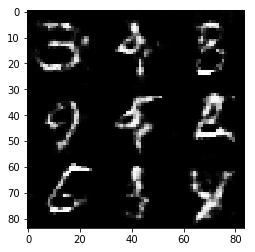

Epoch 1/2... Discriminator Loss: 1.0961... Generator Loss: 0.3220
Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 0.2647
Epoch 1/2... Discriminator Loss: 0.9697... Generator Loss: 0.4317
Epoch 1/2... Discriminator Loss: 0.8383... Generator Loss: 0.4133
Epoch 1/2... Discriminator Loss: 1.1489... Generator Loss: 0.5226


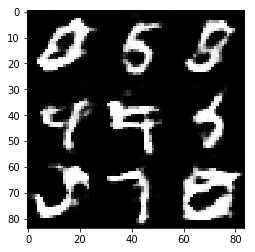

Epoch 1/2... Discriminator Loss: 1.1000... Generator Loss: 0.3632
Epoch 1/2... Discriminator Loss: 1.7562... Generator Loss: 0.1396
Epoch 1/2... Discriminator Loss: 1.3072... Generator Loss: 0.5531
Epoch 1/2... Discriminator Loss: 1.1577... Generator Loss: 0.2608
Epoch 1/2... Discriminator Loss: 0.7508... Generator Loss: 0.4996


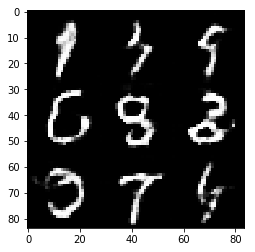

Epoch 1/2... Discriminator Loss: 1.3437... Generator Loss: 0.9343
Epoch 1/2... Discriminator Loss: 1.5056... Generator Loss: 0.3698
Epoch 1/2... Discriminator Loss: 1.0385... Generator Loss: 0.4591
Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 0.2488
Epoch 1/2... Discriminator Loss: 0.4940... Generator Loss: 0.8692


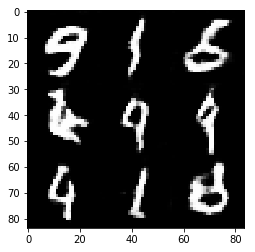

Epoch 1/2... Discriminator Loss: 0.5644... Generator Loss: 0.7370
Epoch 1/2... Discriminator Loss: 0.9563... Generator Loss: 0.5932
Epoch 1/2... Discriminator Loss: 0.8556... Generator Loss: 0.5152
Epoch 1/2... Discriminator Loss: 0.7691... Generator Loss: 0.3961
Epoch 1/2... Discriminator Loss: 1.2737... Generator Loss: 0.5213


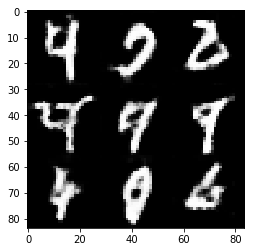

Epoch 1/2... Discriminator Loss: 1.1013... Generator Loss: 0.3077
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 0.2979
Epoch 1/2... Discriminator Loss: 0.8407... Generator Loss: 0.5266
Epoch 1/2... Discriminator Loss: 0.8282... Generator Loss: 1.0412
Epoch 1/2... Discriminator Loss: 1.0240... Generator Loss: 0.4147


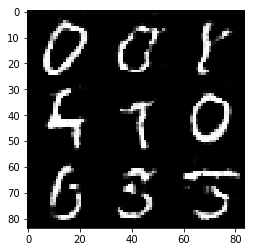

Epoch 1/2... Discriminator Loss: 0.5171... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 0.3856
Epoch 1/2... Discriminator Loss: 0.7310... Generator Loss: 0.9651
Epoch 1/2... Discriminator Loss: 0.4431... Generator Loss: 0.6920
Epoch 1/2... Discriminator Loss: 1.6087... Generator Loss: 0.1898


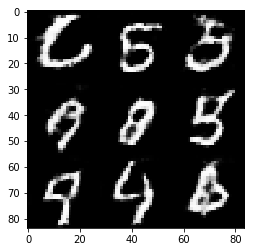

Epoch 1/2... Discriminator Loss: 0.4403... Generator Loss: 0.6536
Epoch 1/2... Discriminator Loss: 0.7314... Generator Loss: 0.6454
Epoch 1/2... Discriminator Loss: 1.1466... Generator Loss: 0.1829
Epoch 1/2... Discriminator Loss: 0.9878... Generator Loss: 0.5785
Epoch 1/2... Discriminator Loss: 0.6321... Generator Loss: 0.6300


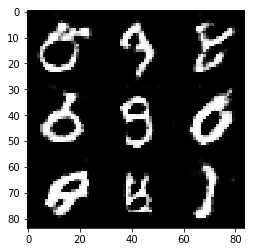

Epoch 1/2... Discriminator Loss: 0.5069... Generator Loss: 0.9561
Epoch 1/2... Discriminator Loss: 0.7184... Generator Loss: 0.9260
Epoch 1/2... Discriminator Loss: 0.6624... Generator Loss: 0.6078
Epoch 1/2... Discriminator Loss: 0.8376... Generator Loss: 0.3415
Epoch 1/2... Discriminator Loss: 0.6773... Generator Loss: 0.4964


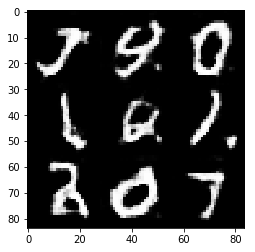

Epoch 2/2... Discriminator Loss: 1.0129... Generator Loss: 0.4103
Epoch 2/2... Discriminator Loss: 1.9385... Generator Loss: 0.3038
Epoch 2/2... Discriminator Loss: 0.8934... Generator Loss: 0.5599
Epoch 2/2... Discriminator Loss: 0.9481... Generator Loss: 0.5136
Epoch 2/2... Discriminator Loss: 0.5858... Generator Loss: 0.4752


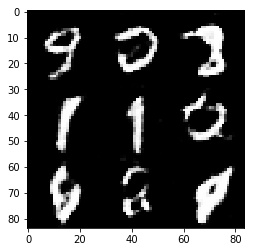

Epoch 2/2... Discriminator Loss: 0.6388... Generator Loss: 0.5903
Epoch 2/2... Discriminator Loss: 0.7003... Generator Loss: 0.9504
Epoch 2/2... Discriminator Loss: 0.7982... Generator Loss: 0.5008
Epoch 2/2... Discriminator Loss: 0.7078... Generator Loss: 0.5529
Epoch 2/2... Discriminator Loss: 0.5704... Generator Loss: 0.4278


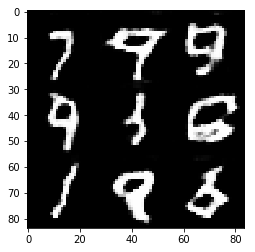

Epoch 2/2... Discriminator Loss: 0.9823... Generator Loss: 0.3323
Epoch 2/2... Discriminator Loss: 0.4024... Generator Loss: 1.2096
Epoch 2/2... Discriminator Loss: 1.6989... Generator Loss: 0.0783
Epoch 2/2... Discriminator Loss: 0.3876... Generator Loss: 0.8410
Epoch 2/2... Discriminator Loss: 0.6155... Generator Loss: 0.4080


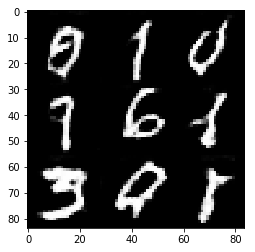

Epoch 2/2... Discriminator Loss: 0.4195... Generator Loss: 1.1138
Epoch 2/2... Discriminator Loss: 0.7906... Generator Loss: 0.4836
Epoch 2/2... Discriminator Loss: 1.3810... Generator Loss: 0.1752
Epoch 2/2... Discriminator Loss: 0.5107... Generator Loss: 0.9697
Epoch 2/2... Discriminator Loss: 0.9029... Generator Loss: 1.1239


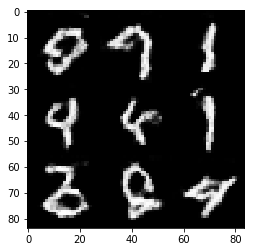

Epoch 2/2... Discriminator Loss: 0.8298... Generator Loss: 0.4591
Epoch 2/2... Discriminator Loss: 1.1624... Generator Loss: 0.2386
Epoch 2/2... Discriminator Loss: 0.4507... Generator Loss: 0.5673
Epoch 2/2... Discriminator Loss: 0.4877... Generator Loss: 0.8887
Epoch 2/2... Discriminator Loss: 0.6434... Generator Loss: 0.4113


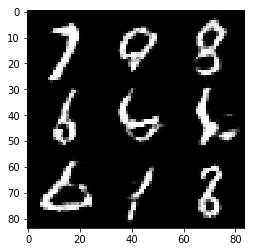

Epoch 2/2... Discriminator Loss: 0.5427... Generator Loss: 0.4211
Epoch 2/2... Discriminator Loss: 0.3270... Generator Loss: 0.9781
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 0.2797
Epoch 2/2... Discriminator Loss: 0.9886... Generator Loss: 0.2706
Epoch 2/2... Discriminator Loss: 1.3353... Generator Loss: 0.3290


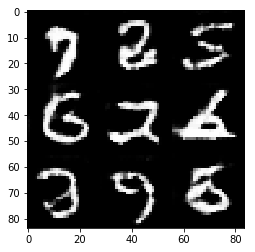

Epoch 2/2... Discriminator Loss: 0.7068... Generator Loss: 0.5409
Epoch 2/2... Discriminator Loss: 0.2677... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 1.3494... Generator Loss: 1.2192
Epoch 2/2... Discriminator Loss: 1.0165... Generator Loss: 0.4374
Epoch 2/2... Discriminator Loss: 0.6211... Generator Loss: 0.5112


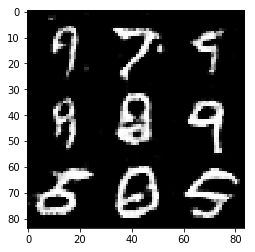

Epoch 2/2... Discriminator Loss: 0.4045... Generator Loss: 0.7634
Epoch 2/2... Discriminator Loss: 0.6106... Generator Loss: 0.4968
Epoch 2/2... Discriminator Loss: 0.6253... Generator Loss: 1.2424
Epoch 2/2... Discriminator Loss: 0.3902... Generator Loss: 0.6346
Epoch 2/2... Discriminator Loss: 0.6473... Generator Loss: 0.7137


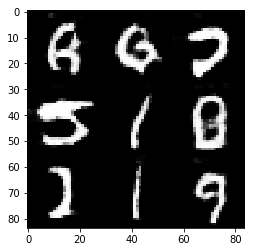

Epoch 2/2... Discriminator Loss: 0.7566... Generator Loss: 0.3477
Epoch 2/2... Discriminator Loss: 0.2121... Generator Loss: 1.0410
Epoch 2/2... Discriminator Loss: 0.4967... Generator Loss: 0.6701
Epoch 2/2... Discriminator Loss: 0.3430... Generator Loss: 1.5549
Epoch 2/2... Discriminator Loss: 0.7246... Generator Loss: 0.8558


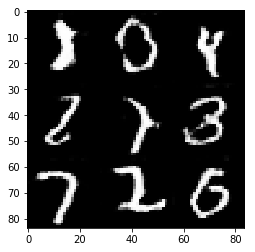

Epoch 2/2... Discriminator Loss: 0.3981... Generator Loss: 0.6436
Epoch 2/2... Discriminator Loss: -0.0267... Generator Loss: 0.7943
Epoch 2/2... Discriminator Loss: 0.5716... Generator Loss: 0.3054
Epoch 2/2... Discriminator Loss: 1.7742... Generator Loss: 2.1582
Epoch 2/2... Discriminator Loss: 0.8795... Generator Loss: 0.4581


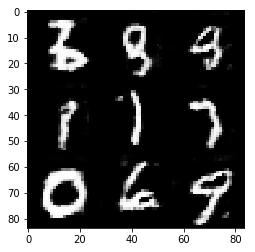

Epoch 2/2... Discriminator Loss: 0.2443... Generator Loss: 0.8006
Epoch 2/2... Discriminator Loss: 0.7113... Generator Loss: 0.3220
Epoch 2/2... Discriminator Loss: 0.4397... Generator Loss: 1.3999
Epoch 2/2... Discriminator Loss: 0.7638... Generator Loss: 0.2288
Epoch 2/2... Discriminator Loss: 1.5544... Generator Loss: 0.2677


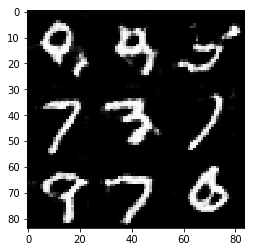

Epoch 2/2... Discriminator Loss: 0.3845... Generator Loss: 0.9431
Epoch 2/2... Discriminator Loss: 0.2734... Generator Loss: 0.4554
Epoch 2/2... Discriminator Loss: 0.3931... Generator Loss: 1.1799
Epoch 2/2... Discriminator Loss: 0.1751... Generator Loss: 1.2992
Epoch 2/2... Discriminator Loss: 0.6045... Generator Loss: 0.5551


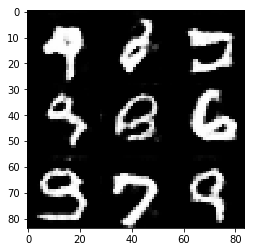

Epoch 2/2... Discriminator Loss: 0.3486... Generator Loss: 0.6472
Epoch 2/2... Discriminator Loss: 0.5538... Generator Loss: 0.4738
Epoch 2/2... Discriminator Loss: 0.8047... Generator Loss: 0.4139
Epoch 2/2... Discriminator Loss: 0.1668... Generator Loss: 1.2230
Epoch 2/2... Discriminator Loss: 0.4174... Generator Loss: 0.4981


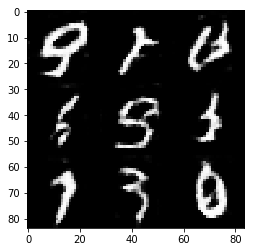

Epoch 2/2... Discriminator Loss: 0.4266... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 0.2239... Generator Loss: 0.7307
Epoch 2/2... Discriminator Loss: 1.3023... Generator Loss: 0.1109
Epoch 2/2... Discriminator Loss: 0.9819... Generator Loss: 0.6159
Epoch 2/2... Discriminator Loss: 0.4438... Generator Loss: 0.5348


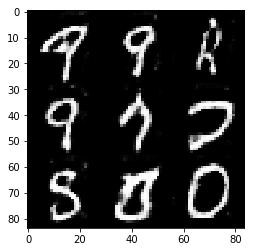

Epoch 2/2... Discriminator Loss: 0.6110... Generator Loss: 0.4218
Epoch 2/2... Discriminator Loss: 0.2929... Generator Loss: 0.5572
Epoch 2/2... Discriminator Loss: 0.3170... Generator Loss: 0.6269
Epoch 2/2... Discriminator Loss: 0.2528... Generator Loss: 0.5830
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 2.0666


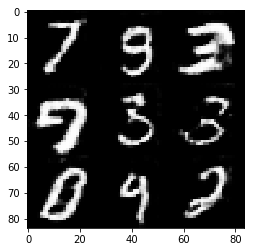

Epoch 2/2... Discriminator Loss: 0.1520... Generator Loss: 0.7394
Epoch 2/2... Discriminator Loss: 1.4052... Generator Loss: 0.1805
Epoch 2/2... Discriminator Loss: 0.6288... Generator Loss: 2.0109
Epoch 2/2... Discriminator Loss: 0.9945... Generator Loss: 0.2353
Epoch 2/2... Discriminator Loss: 0.5424... Generator Loss: 2.0315


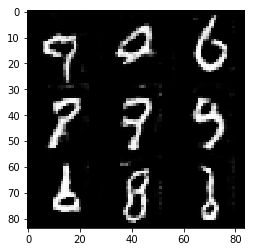

Epoch 2/2... Discriminator Loss: 0.7575... Generator Loss: 1.4610
Epoch 2/2... Discriminator Loss: 0.8147... Generator Loss: 0.3789
Epoch 2/2... Discriminator Loss: 0.3549... Generator Loss: 0.5070
Epoch 2/2... Discriminator Loss: 0.3991... Generator Loss: 0.5681
Epoch 2/2... Discriminator Loss: 0.7127... Generator Loss: 0.4470


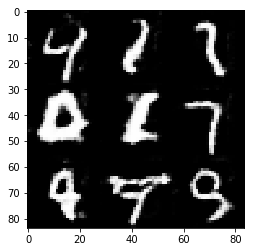

Epoch 2/2... Discriminator Loss: 0.4994... Generator Loss: 0.4912
Epoch 2/2... Discriminator Loss: 1.7614... Generator Loss: 0.1181
Epoch 2/2... Discriminator Loss: 0.6920... Generator Loss: 0.7223
Epoch 2/2... Discriminator Loss: -0.3161... Generator Loss: 0.8025
Epoch 2/2... Discriminator Loss: 0.3595... Generator Loss: 1.6655


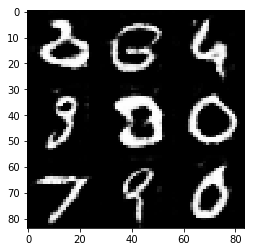

Epoch 2/2... Discriminator Loss: 0.3500... Generator Loss: 2.7679
Epoch 2/2... Discriminator Loss: -0.2409... Generator Loss: 0.9058
Epoch 2/2... Discriminator Loss: 0.7350... Generator Loss: 0.4049
Epoch 2/2... Discriminator Loss: 0.4346... Generator Loss: 3.1933
Epoch 2/2... Discriminator Loss: 0.0861... Generator Loss: 1.7057


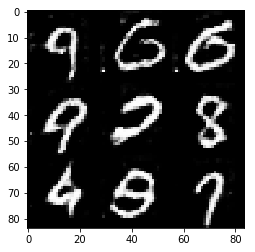

Epoch 2/2... Discriminator Loss: 0.9681... Generator Loss: 3.4465
Epoch 2/2... Discriminator Loss: -0.0127... Generator Loss: 1.0728
Epoch 2/2... Discriminator Loss: 0.5245... Generator Loss: 0.6322
Epoch 2/2... Discriminator Loss: -0.2012... Generator Loss: 0.8920
Epoch 2/2... Discriminator Loss: 0.6504... Generator Loss: 2.6955


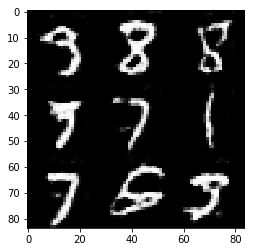

Epoch 2/2... Discriminator Loss: -0.0328... Generator Loss: 1.4583
Epoch 2/2... Discriminator Loss: 0.2668... Generator Loss: 0.4432
Epoch 2/2... Discriminator Loss: 0.1835... Generator Loss: 1.0077
Epoch 2/2... Discriminator Loss: 0.1242... Generator Loss: 1.2973
Epoch 2/2... Discriminator Loss: 0.2231... Generator Loss: 0.4262


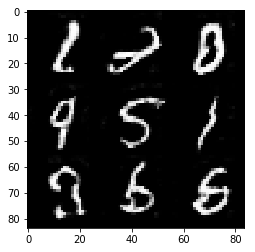

Epoch 2/2... Discriminator Loss: 0.3487... Generator Loss: 0.6431
Epoch 2/2... Discriminator Loss: -0.0406... Generator Loss: 1.9852
Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 0.4981
Epoch 2/2... Discriminator Loss: -0.0699... Generator Loss: 0.3629
Epoch 2/2... Discriminator Loss: 4.6516... Generator Loss: 0.0075


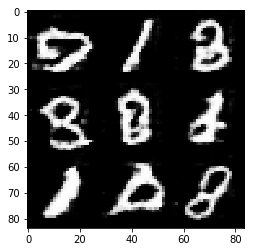

Epoch 2/2... Discriminator Loss: 0.9033... Generator Loss: 1.5881
Epoch 2/2... Discriminator Loss: 0.4206... Generator Loss: 1.4482
Epoch 2/2... Discriminator Loss: 0.7721... Generator Loss: 0.6452
Epoch 2/2... Discriminator Loss: 0.4456... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 0.6616... Generator Loss: 0.6090


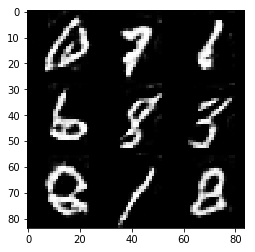

Epoch 2/2... Discriminator Loss: 0.2815... Generator Loss: 1.1532
Epoch 2/2... Discriminator Loss: 0.3984... Generator Loss: 0.3475
Epoch 2/2... Discriminator Loss: 0.7865... Generator Loss: 0.3800
Epoch 2/2... Discriminator Loss: 0.1405... Generator Loss: 0.6136
Epoch 2/2... Discriminator Loss: -0.0842... Generator Loss: 0.9147


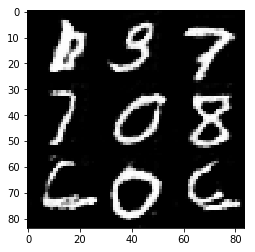

In [17]:
batch_size = 50
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.3087... Generator Loss: 0.3156
Epoch 1/1... Discriminator Loss: 1.6052... Generator Loss: 3.5083
Epoch 1/1... Discriminator Loss: 1.7224... Generator Loss: 3.2460
Epoch 1/1... Discriminator Loss: 1.7534... Generator Loss: 0.3284
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 1.3925


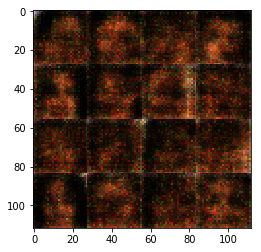

Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 1.8955
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 2.0034
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 1.2561


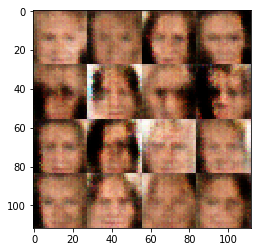

Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 1.9635
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.4569
Epoch 1/1... Discriminator Loss: 1.7439... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 0.8285... Generator Loss: 1.4721


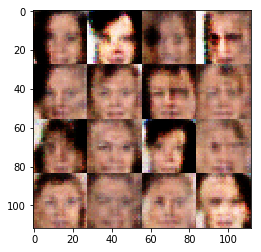

Epoch 1/1... Discriminator Loss: 1.6250... Generator Loss: 2.8426
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 1.2457
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.7788


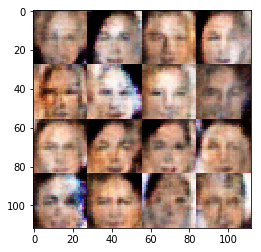

Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 1.4680
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.5418... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.9748


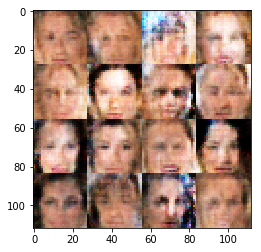

Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 1.4038
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.9667... Generator Loss: 2.5168
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.9428


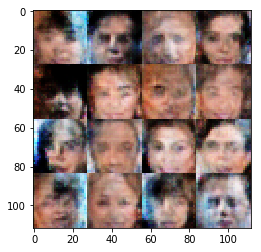

Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 1.1479
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 1.0104
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.8611


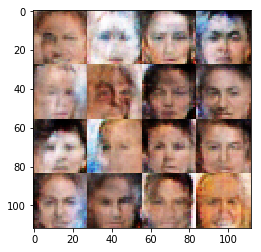

Epoch 1/1... Discriminator Loss: 2.1987... Generator Loss: 2.9016
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 1.0807
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 1.6012
Epoch 1/1... Discriminator Loss: 1.5787... Generator Loss: 0.4794


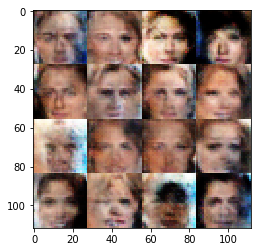

Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 1.2292
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.5365... Generator Loss: 1.9306


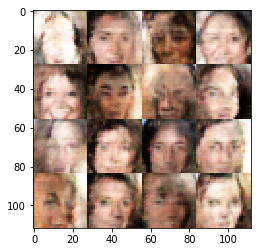

Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 1.2967
Epoch 1/1... Discriminator Loss: 1.6754... Generator Loss: 2.1772
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 1.7928
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7254


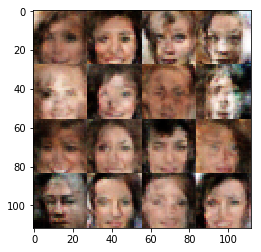

Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.4599
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 1.8163
Epoch 1/1... Discriminator Loss: 1.5848... Generator Loss: 2.0136
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6147


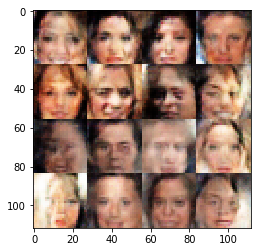

Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.6161... Generator Loss: 1.8996
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 1.0678


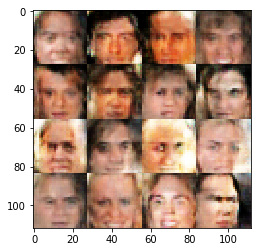

Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 1.2778
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 1.7392
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 1.2468
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.9441


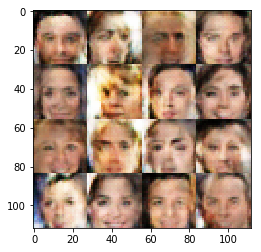

Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 1.6531
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.9810


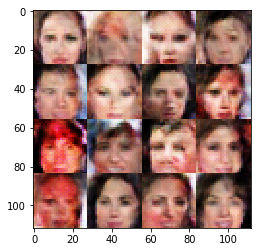

Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 1.8496
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.4964
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 1.0674


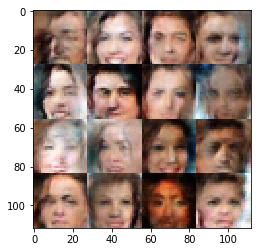

Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.8264


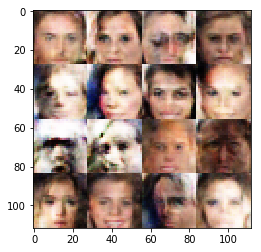

Epoch 1/1... Discriminator Loss: 1.8740... Generator Loss: 2.2637
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 0.7641


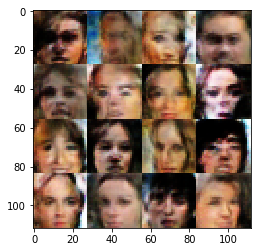

Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 2.8359
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.6209


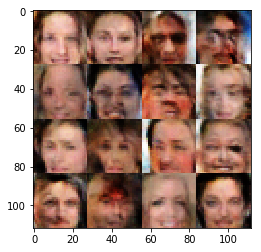

Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 1.7101
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.6982


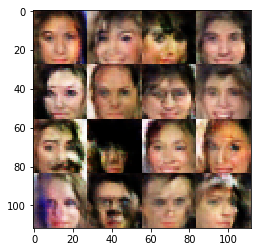

Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 1.5390
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 1.2606
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 1.2685
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 2.0119
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 1.0701


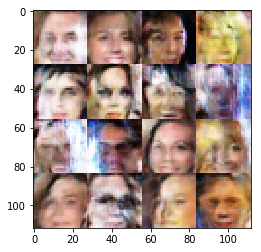

Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 1.2357
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 1.2709
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.3448
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.6095


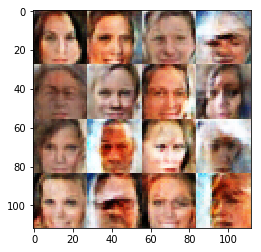

Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 1.3944


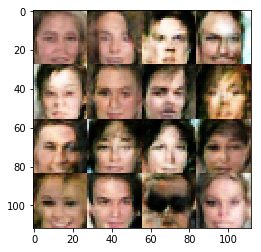

Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 1.0810
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 1.2951
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 1.1704


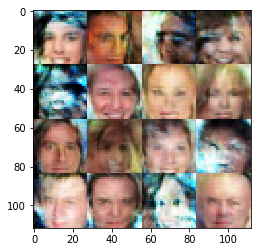

Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 1.0731
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 1.9515
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.5190


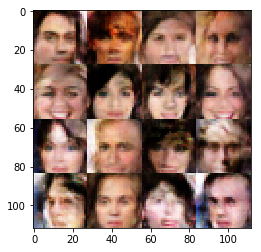

Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 1.0139
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 1.4441


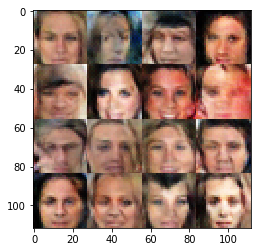

Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 1.6893
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 1.7286
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.9470


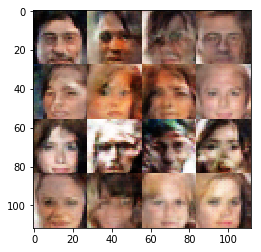

Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 1.7555
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 1.8339
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 1.1383
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.7538


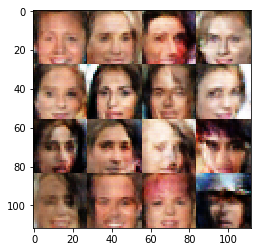

Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 1.4834
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 1.3703
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 1.1337


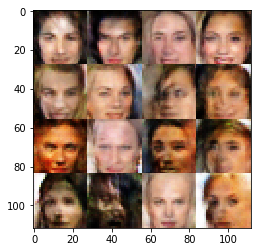

Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 1.2119
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 1.3474
Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 2.0302


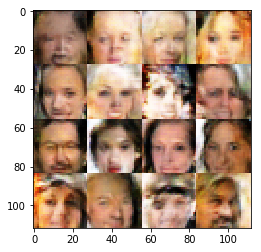

Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 1.1075
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 1.8108
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.1846


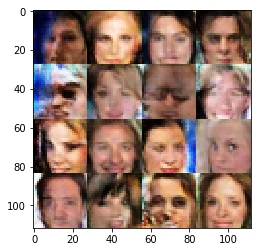

Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 1.4174
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.2142
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 0.9629


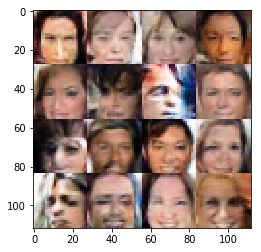

Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 1.5154
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 1.1237
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 1.3175
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.7405


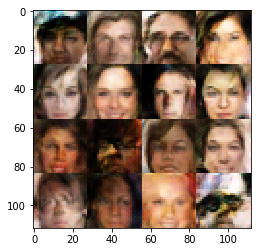

Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 1.0392
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.2910
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.6184


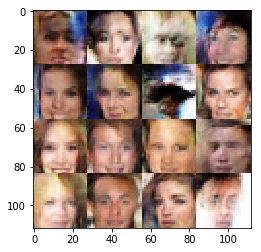

Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 1.6296
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 1.5894
Epoch 1/1... Discriminator Loss: 1.6673... Generator Loss: 0.3829
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 0.9198


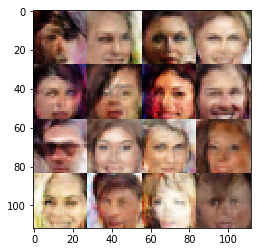

Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 1.3859
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.3590
Epoch 1/1... Discriminator Loss: 1.6204... Generator Loss: 1.3101
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 1.3783


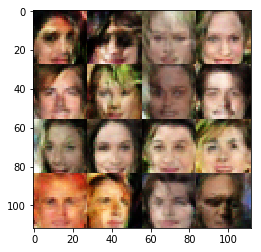

Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 1.3029
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 1.6001


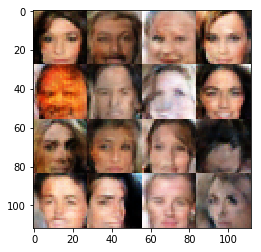

Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 1.8694
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 1.2710


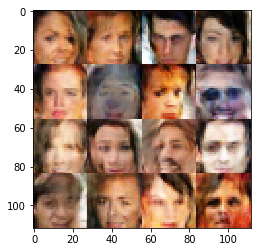

Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 1.2430
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 1.1482
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 1.1436


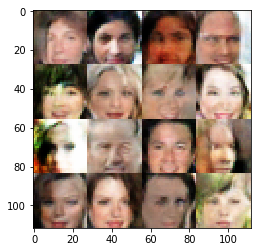

Epoch 1/1... Discriminator Loss: 1.6912... Generator Loss: 0.3620
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 1.1499
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.9207


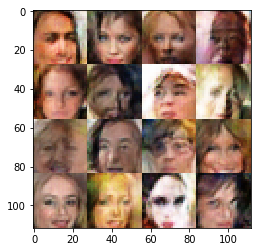

Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 1.1227
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 1.7908
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 0.9900


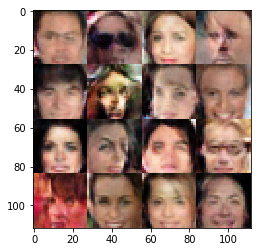

Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 1.5900
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 1.3851
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.7274


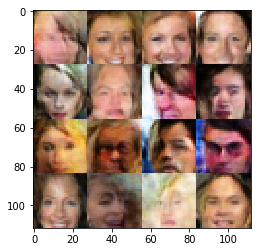

Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 1.2399
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 1.1477


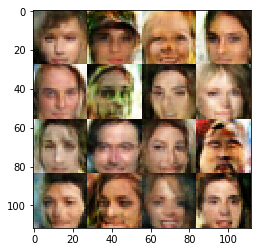

Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 2.0251
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 1.4094
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 2.0553
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.0893


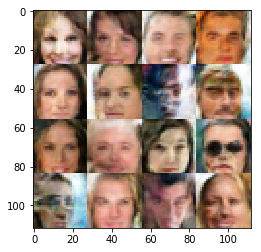

Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 1.7116
Epoch 1/1... Discriminator Loss: 0.8195... Generator Loss: 1.4460
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.3644


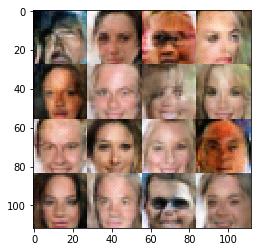

Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 1.8975
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 1.3596
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.5872
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 1.9822


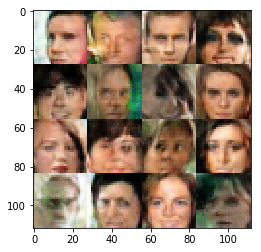

Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.2288
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.0597


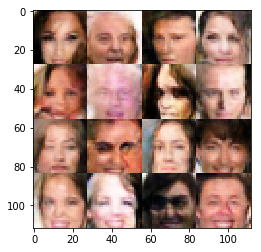

Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 1.3289
Epoch 1/1... Discriminator Loss: 0.9324... Generator Loss: 1.7095
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 1.3938
Epoch 1/1... Discriminator Loss: 1.6472... Generator Loss: 2.0955
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.5323


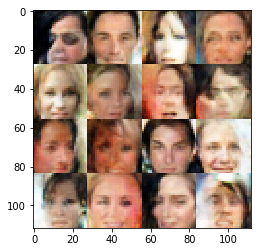

Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 1.4628
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 1.6082
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 1.1582


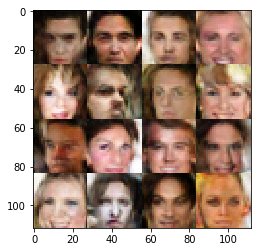

Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 1.5933
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.8151... Generator Loss: 3.2461
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 1.5294
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 1.7271


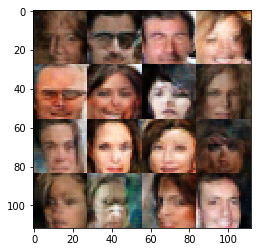

Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 1.7696
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 2.0284
Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 1.1245
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 1.5902
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.7427


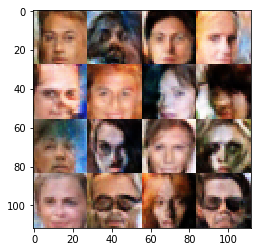

Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 1.0853


In [ ]:
batch_size = 40
z_dim = 100
learning_rate = 0.0008
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.